In [ ]:
#%pip install --upgrade tensorflow

In [1]:
import tensorflow as tf
import os

# Definizione dei parametri di caricamento delle immagini
batch_size = 32
image_size = (816, 612)
directory = '../Dataset/JPEGImages/T'
test_split = 0.2

image_files = os.listdir(directory)
# Caricamento delle immagini dalla directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    class_names=None,
    batch_size=batch_size,
    validation_split=test_split,
    subset="training",
    seed=123
)

class_names = os.listdir(directory)
print("Nomi delle classi:", class_names)

# Calcolo del numero di campioni per il set di test
num_samples = train_dataset.cardinality().numpy()
num_test_samples = int(num_samples * test_split)

# Divisione del set di addestramento in set di addestramento e test
test_dataset = train_dataset.take(num_test_samples)
train_dataset = train_dataset.skip(num_test_samples)

Found 1477 files belonging to 20 classes.
Using 1182 files for training.
Nomi delle classi: ['Apple', 'Banana', 'Bread', 'Bun', 'Doughnut', 'Egg', 'Fired_dough', 'Grape', 'Lemon', 'Litchi', 'Mango', 'Mix', 'Mooncake', 'Orange', 'Peach', 'Pear', 'Plum', 'Qiwi', 'Sachima', 'Tomato']


In [ ]:
%pip install tensorflow
%pip install tf_slim
%pip install tensorflow-hub
%pip install tensorflow-object-detection-api
%pip install tf-models-official
%pip install opencv-python


In [ ]:
import tensorflow as tf
import cv2
import numpy as np
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

# Percorso al modello pre-addestrato
PATH_TO_SAVED_MODEL = '../Preprocessed/faster_rcnn_resnet152_v1_1024x1024_coco17_tpu-8.config'  # Sostituisci con il percorso del modello pre-addestrato

# Percorso alla mappa delle etichette
PATH_TO_LABELS = '../Dataset/JPEGImages/T'  # Sostituisci con il percorso della mappa delle etichette

# Carica il modello pre-addestrato
model = tf.saved_model.load()

# Carica la mappa delle etichette
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

# Effettua il rilevamento oggetti
detections = model(PATH_TO_LABELS)

# Visualizza i risultati del rilevamento
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np,
    detections['detection_boxes'][0].numpy(),
    (detections['detection_classes'][0].numpy() + 1).astype(int),
    detections['detection_scores'][0].numpy(),
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=0.3,
    agnostic_mode=False
)

# Mostra l'immagine con le detection
image_np = cv2.imread(image_path)
image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
cv2.imshow('Object Detection', image_np)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [ ]:
#%pip install object_detection
#%pip install utils
%pip install protobuf-compiler

In [ ]:
%pip install protobuf

In [5]:
#QUESTO
import os
import numpy as np
import tensorflow as tf
from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as vis_util
from PIL import Image
import pathlib

def load_model(model_name):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(
      fname=model_name, 
      origin=base_url + model_file,
      untar=True)

    model_dir = pathlib.Path(model_dir)/"saved_model"
    model = tf.saved_model.load(str(model_dir))
    return model

def run_inference_for_single_image(model, image):
    image = np.asarray(image)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis,...]

    # Run inference
    model_fn = model.signatures['serving_default']
    output_dict = model_fn(input_tensor)

    # All outputs are batches tensors.
    # Convert to numpy arrays, and take index [0] to remove the batch dimension.
    # We're only interested in the first num_detections.
    num_detections = int(output_dict.pop('num_detections'))
    output_dict = {key:value[0, :num_detections].numpy() 
                  for key,value in output_dict.items()}
    output_dict['num_detections'] = num_detections

    # detection_classes should be ints.
    output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)   

    # Handle models with masks:
    if 'detection_masks' in output_dict:
        # Reframe the the bbox mask to the image size.
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                  output_dict['detection_masks'], output_dict['detection_boxes'],
                   image.shape[0], image.shape[1])      
        detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                           tf.uint8)
        output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()  
    
    return output_dict

def show_inference(model, image_path, category_index):
# Load image using PIL
    image = Image.open(image_path)
    image_np = np.array(image, dtype=np.uint8)
    
    # Actual detection.
    output_dict = run_inference_for_single_image(model, image_np)
    
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks_reframed', None),
        use_normalized_coordinates=True,
        line_thickness=5)

    return image_np

def read_label_map(label_map_path):
    category_index = {}
    with open(label_map_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.strip()
            if line.startswith('name:'):
                name = line[len('name:'):].strip().strip('\'"')
            elif line.startswith('id:'):
                class_id = int(line[len('id:'):])
                category_index[class_id] = {'id': class_id, 'name': name}
                
    return category_index

Il file esiste nel percorso specificato.
Categoria ID: 1, Nome: /m/01g317
Categoria ID: 2, Nome: /m/0199g
Categoria ID: 3, Nome: /m/0k4j
Categoria ID: 4, Nome: /m/04_sv
Categoria ID: 5, Nome: /m/05czz6l
Categoria ID: 6, Nome: /m/01bjv
Categoria ID: 7, Nome: /m/07jdr
Categoria ID: 8, Nome: /m/07r04
Categoria ID: 9, Nome: /m/019jd
Categoria ID: 10, Nome: /m/015qff
Categoria ID: 11, Nome: /m/01pns0
Categoria ID: 13, Nome: /m/02pv19
Categoria ID: 14, Nome: /m/015qbp
Categoria ID: 15, Nome: /m/0cvnqh
Categoria ID: 16, Nome: /m/015p6
Categoria ID: 17, Nome: /m/01yrx
Categoria ID: 18, Nome: /m/0bt9lr
Categoria ID: 19, Nome: /m/03k3r
Categoria ID: 20, Nome: /m/07bgp
Categoria ID: 21, Nome: /m/01xq0k1
Categoria ID: 22, Nome: /m/0bwd_0j
Categoria ID: 23, Nome: /m/01dws
Categoria ID: 24, Nome: /m/0898b
Categoria ID: 25, Nome: /m/03bk1
Categoria ID: 27, Nome: /m/01940j
Categoria ID: 28, Nome: /m/0hnnb
Categoria ID: 31, Nome: /m/080hkjn
Categoria ID: 32, Nome: /m/01rkbr
Categoria ID: 33, Nome: /m/0

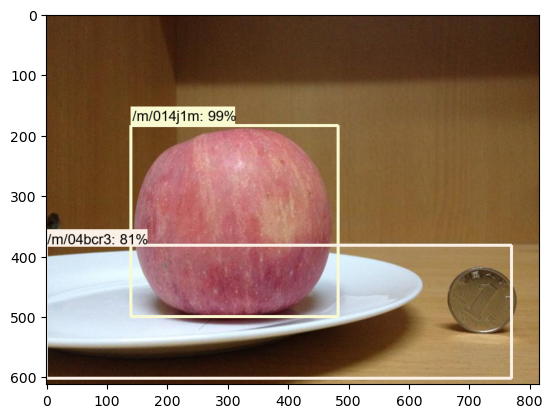

In [7]:
#QUESTO
from matplotlib import pyplot as plt
import os
import tensorflow as tf
from object_detection.utils import label_map_util

# Set the paths
model_name = 'faster_rcnn_resnet101_v1_640x640_coco17_tpu-8'
image_path = '..\Dataset\JPEGImages\Apple\S_Apple\\apple002S(5).JPG'

# Load the model
model = load_model(model_name)

# Load the label map
label_map_path = '..\\tf_models\\research\\object_detection\\data\\mscoco_label_map.pbtxt'
category_index = None 

if os.path.isfile(label_map_path):
    print("Il file esiste nel percorso specificato.")

    with open(label_map_path, 'r') as f:
        label_map = f.read()

    # Prosegui con la creazione di category_index solo se esiste label_map
    category_index = read_label_map(label_map_path)

    for category_id, category_info in category_index.items():
        print(f"Categoria ID: {category_id}, Nome: {category_info['name']}")
else:
    print("Il file NON esiste nel percorso specificato.")

# Run inference and display the results
image_np = show_inference(model, image_path, category_index)
#Display the image with the detected objects
#serve per far funzionare il plt
%matplotlib inline 
plt.imshow(image_np)
plt.show()


In [ ]:
# Calcolo delle metriche (assumendo che hai le etichette vere
#y_true = 
#y_pred = 

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')

# Stampa delle metriche
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Recall:", recall)
print("Precision:", precision)